[('HG00514', 'CLR'), ('HG00514', 'HiFi'), ('HG02818', 'HiFi'), ('HG03009', 'CLR'), ('HG03125', 'HiFi'), ('HG03486', 'HiFi'), ('NA12329', 'CLR')]
---------------


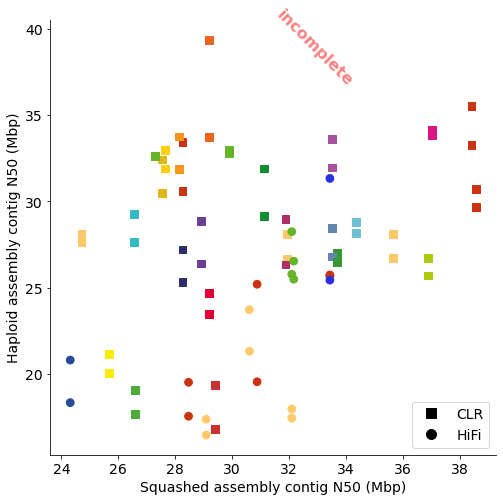

In [28]:
import os
import collections as col
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/fig1_panels/contig_stats'
out_path = os.path.join(stats_path, pipeline_version, 'fig1_panel_contiguity-stats')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))

keep_infos = {
    4: 'num_contigs_all',
    16: 'num_contigs_geq_3kb',
    17: 'largest_contig_bp',
    18: 'total_length_geq3kb_bp',
    20: 'GC_pct',
    22: 'N50',
    23: 'NG50',
    24: 'N75',
    25: 'NG75',
    30: 'num_misassemblies',
    40: 'ref_genome_fraction_pct',
    41: 'dup_ratio',
    45: 'num_genomic_feat',
    48: 'largest_alignment_bp',
    49: 'total_aligned_length_bp'
}

def load_assembly_stats(file_path):
    assm_stats = dict()
    with open(file_path, 'r') as table:
        for ln, line in enumerate(table, start=1):
            if ln not in keep_infos:
                continue
            key = keep_infos[ln]
            parts = line.strip().split()
            if key == 'num_genomic_feat':
                key_complete = key + '_complete'
                key_partial = key + '_partial'
                assm_stats[key_complete] = int(parts[-4])
                assm_stats[key_partial] = int(parts[-2])
                continue
            to_num = int
            if any(key.endswith(x) for x in ['pct', 'ratio']):
                to_num = float
            try:
                assm_stats[key] = to_num(parts[-1])
            except ValueError:
                raise ValueError('Cannot convert number: {} / {} / {}'.format(ln, line.strip(), file_path))
    return assm_stats


def extract_assembly_type(file_name):
    assmt = None
    if '_nhr-' in file_name:
        assmt = 'NHR', 0
    elif 'h1-un' in file_name:
        assmt = 'HAP', 1
    elif 'h2-un' in file_name:
        assmt = 'HAP', 2
    else:
        raise ValueError('ASSMT: {}'.format(file_name))
    if assmt is None:
        raise ValueError('ASSMT: {}'.format(file_name))
    return assmt


if not os.path.isfile(cache_file):
    stat_files = plot_aux.load_plot_data_files(
        stats_path,
        '.txt',
        pipeline_version)
    plot_data = [load_assembly_stats(fp) for fp in stat_files]

    sample_platform = [plot_aux.extract_sample_platform(os.path.basename(f)) for f in stat_files]
    assembly_types = [extract_assembly_type(os.path.basename(f)) for f in stat_files]
    row_index = []
    for (sample, platform), (assmt, hap) in zip(sample_platform, assembly_types):
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform, assmt, hap))

    df = pd.DataFrame(
        plot_data,
        columns=sorted(plot_data[0].keys()),
        index=row_index
    )

    df.index = pd.MultiIndex.from_tuples(
        df.index.values,
        names=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap']
    )
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap'])        

errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print(sorted(missing))
    print('---------------')

def plot_assembly_contiguity(sample_stats):
    
    nhr_assm = sample_stats.xs('NHR', level='assembly', drop_level=False)
    
    x_vals = col.defaultdict(list)
    y_vals = col.defaultdict(list)
    colors = col.defaultdict(list)
    
    for idx, row in nhr_assm.iterrows():
        platform = idx[3]
        population = idx[2]
        
        x_vals[platform].append(round(row['N50'] / 1e6, 2))
        
        hap1_index = (idx[0], idx[1], idx[2], idx[3], 'HAP', 1)
        y_vals[(platform, 'HAP1')].append(round(sample_stats.loc[hap1_index, 'N50'] / 1e6, 2))
        
        hap2_index = (idx[0], idx[1], idx[2], idx[3], 'HAP', 2)
        y_vals[(platform, 'HAP2')].append(round(sample_stats.loc[hap2_index, 'N50'] / 1e6, 2))
        
        colors[platform].append(rgbcodes[population])
        
    
    fig, axis = plt.subplots(figsize=(8,8))
    
    for platform in plot_aux.get_sequencing_platforms():
        for hap in ['HAP1', 'HAP2']:
            nhr_n50 = x_vals[platform]
            hap_n50 = y_vals[(platform, hap)]
            marker_colors = colors[platform]

            axis.scatter(
                nhr_n50,
                hap_n50,
                s=prop('plot_marker_size'),
                c=colors[platform],
                marker=prop('{}_marker'.format(platform))
            )

    axis.set_xlabel(
        'Squashed assembly contig N50 (Mbp)',
        fontsize=prop('fontsize_legend')
    )
    axis.set_ylabel(
        'Haploid assembly contig N50 (Mbp)',
        fontsize=prop('fontsize_legend')
    )
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    
    # build custom legend
    custom_lines = [
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker=prop('CLR_marker'),
            ls='None',
            label='CLR'
        ),
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker=prop('HiFi_marker'),
            ls='None',
            label='HiFi'
        )   
    ]
    
    axis.legend(
        handles=custom_lines,
        loc='lower right',
        prop={'size': prop('fontsize_legend')}
    )

    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.5, 0.85)
    
    extra_artists = []
    
    return fig, extra_artists
        
fig, exart = plot_assembly_contiguity(df)
    
fig.savefig(out_path + '.png', dpi=600, bbox_inches='tight', extra_artists=exart)
fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
